In [1]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.sql import SparkSession
from graphviz import Digraph
import random

spark = SparkSession.builder.appName("DecisionTreeVisualization").getOrCreate()

random.seed(42)
data = [
    (
        f"Country_{i}",
        random.uniform(1, 20),  # GDP
        random.uniform(60, 85),  # Life Expectancy
        random.uniform(2, 10),  # Education Spending
        random.uniform(5, 15),  # CO2 Emissions
        1 if i % 2 == 0 else 0  # Target: High Development
    )
    for i in range(1, 100)
]
columns = ["Country", "GDP", "Life Expectancy", "Education Spending", "CO2 Emissions", "High Development"]

df = spark.createDataFrame(data, columns)

features = ["GDP", "Life Expectancy", "Education Spending", "CO2 Emissions"]

assembler = VectorAssembler(inputCols=features, outputCol="features")
df = assembler.transform(df)

dt = DecisionTreeClassifier(labelCol="High Development", featuresCol="features", maxDepth=4)
model = dt.fit(df)


DecisionTreeClassificationModel: uid=DecisionTreeClassifier_d24ded76ec8a, depth=4, numNodes=11, numClasses=2, numFeatures=4
  If (feature 2 <= 9.808912259247514)
   If (feature 0 <= 14.847398646069271)
    If (feature 3 <= 14.172593146353725)
     Predict: 0.0
    Else (feature 3 > 14.172593146353725)
     If (feature 1 <= 65.41335072945581)
      Predict: 0.0
     Else (feature 1 > 65.41335072945581)
      Predict: 1.0
   Else (feature 0 > 14.847398646069271)
    If (feature 3 <= 13.596864767861398)
     Predict: 1.0
    Else (feature 3 > 13.596864767861398)
     Predict: 0.0
  Else (feature 2 > 9.808912259247514)
   Predict: 1.0



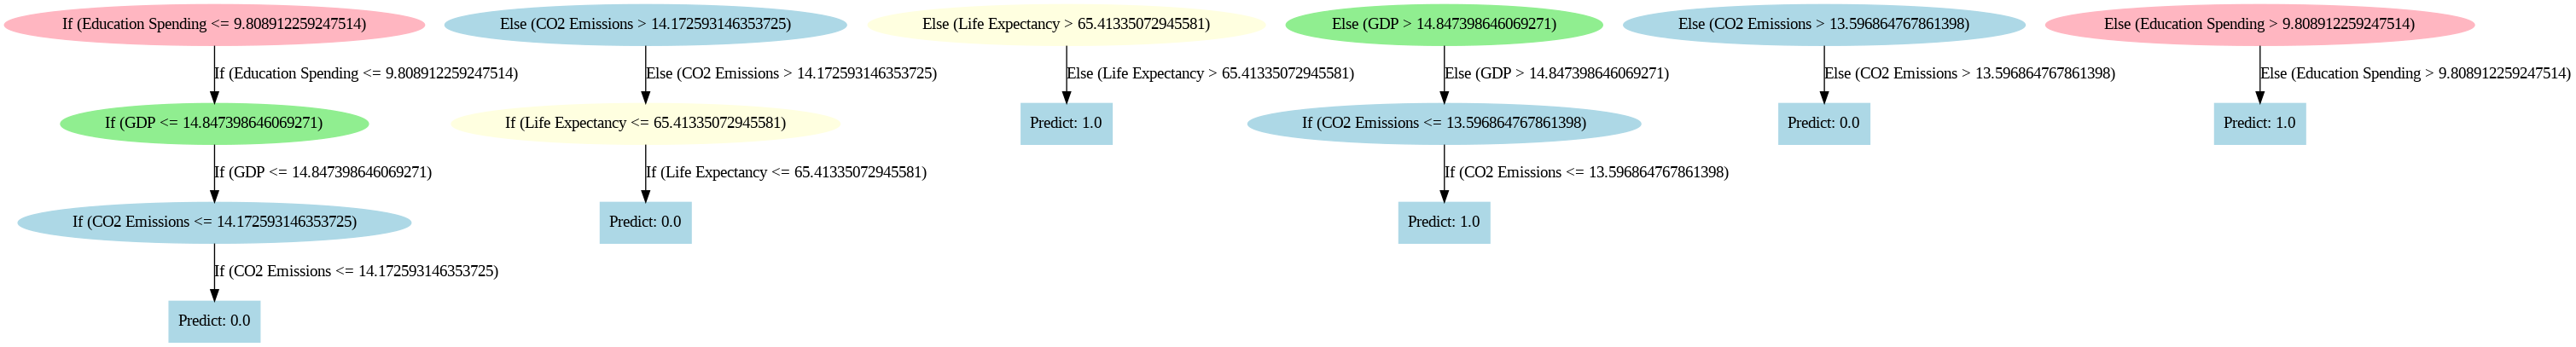

In [2]:
feature_colors = {
    "GDP": "lightgreen",
    "Life Expectancy": "lightyellow",
    "Education Spending": "lightpink",
    "CO2 Emissions": "lightblue"
}

def parse_tree_with_feature_colors(rules, feature_names, feature_colors):
    dot = Digraph(comment='Decision Tree')
    rule_lines = rules.splitlines()

    node_id = 0
    parent_stack = []

    for line in rule_lines:
        line = line.strip()

        for idx, feature in enumerate(feature_names):
            if f"feature {idx}" in line:
                line = line.replace(f"feature {idx}", feature)

        node_color = "lightgray"
        for feature, color in feature_colors.items():
            if feature in line:
                node_color = color
                break

        if "Predict:" in line:
            dot.node(
                f'node_{node_id}',
                line,
                shape="box",
                style="filled",
                color="lightblue",
                fontcolor="black"
            )
            if parent_stack:
                parent, condition = parent_stack.pop()
                dot.edge(parent, f'node_{node_id}', label=condition)
        elif "If" in line or "Else" in line:
            dot.node(
                f'node_{node_id}',
                line,
                shape="ellipse",
                style="filled",
                color=node_color,
                fontcolor="black"
            )
            if parent_stack:
                parent, condition = parent_stack.pop()
                dot.edge(parent, f'node_{node_id}', label=condition)
            parent_stack.append((f'node_{node_id}', line))
        node_id += 1

    return dot

rules = model.toDebugString
print(rules)

colorful_dot = parse_tree_with_feature_colors(rules, features, feature_colors)
colorful_dot.render('decision_tree_feature_colored', format='png', cleanup=True)

from IPython.display import Image
Image(filename='decision_tree_feature_colored.png')


* Education Spending has a dominant role in determining whether the model predicts positive (1.0) or continues to evaluate further.

* GDP and CO2 Emissions play crucial roles in determining the final class, with GDP influencing the path and CO2 Emissions refining the decision.

* Life Expectancy is a critical deciding factor for the model in cases where CO2 Emissions are higher, particularly predicting the positive class (1.0) for higher values.